# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Project Overview
This project is all about analyzing and predicting the churn rate of the users from the data provided by a fictional music streaming company called 'Sparkify'. Users used this platform as a free member and paid member. While using the service data is generated in terms of playing a song, visiting a page etc.. According to the company some users downgraded their services from paid to free and some leave the services after using it for some time. So the main purpose of this project is to design a model that can predict the churn rate of the users according to the data provided.

# Problem Statement
Predict the churn rate of the users i.e if a user downgrade his/her services to free from paid subscription or leave the services/deactivate his/her account from the platform. For this purpose a machine learning model will be build from using different features to predict the churn of a new customer according to his/her activity while using the Sparkify platform.

The full dataset is about 12 GB in space which is suitable for Amazon EMR cluster while we use the mini dataset that is 128 MB in size to carry on the task and prepare all the necessary tasks before going for the full dataset. Apache Spark engine will be used to process and analyze the large scale data and as it is a classfication problem to predict if users churn or not so  following machine learning techniques will be used to predict the churn rate of the users.
1. Linear Regression
2. Random Forest Classifier

Other than these above mentioned models there are other classification models which can be used to check and get even better performance.

# Metrics
f1-score (combination of precision and recall) will be used to measure and evaluate the performance of the machine learning model on the dataset provided.
The main reason to use f1-score to measure the performance is because the churned user data is imbalance in the dataset due to its unequal distribution so to achieve a balanced results f1-score will be used.

### Importing Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, sum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#Loading mini json data
df = spark.read.json('mini_sparkify_event_data.json')
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

#### Dataset size

In [4]:
# Printing rows and columns 
print ('rows: ', df.count())
print ('columns: ' , len(df.columns))

rows:  286500
columns:  18


In [5]:
#showing first 20 rows
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [6]:
#Checking the dataset schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Describing the dataset features like mean, median, standard deviation
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [8]:
# checking the rows in the dataset
df.count()

286500

In [9]:
# checking the summary of userId column of the dataset
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [10]:
# checking the summary of session ID column of the dataset

df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



### Filtering and cleaning the dataset

In [11]:
#checking null values
df.filter('userId is null').count()

0

In [12]:
# checking null values if any
df.filter('sessionId is null').count()

0

In [13]:
# checking empty values in userId
df.filter(df['userId'] == '').count()

8346

In [14]:
# checking empty values in sessionId

df.filter(df['sessionId'] == '').count()

0

In [15]:
# saving the clean dataset without empty values of userId
sparkify_clean = df.filter(df['userId'] != '')

In [16]:
# checking number of rows after some cleaning
sparkify_clean.count()

278154

In [17]:
# checking the data types
sparkify_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [18]:
# checking the summary of artist on clean dataset
sparkify_clean.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [19]:
# checking the summary of auth column
sparkify_clean.describe('auth').show()

+-------+---------+
|summary|     auth|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min|Cancelled|
|    max|Logged In|
+-------+---------+



In [20]:
# checking the gender column summary
sparkify_clean.describe('gender').show()

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+



### Converting the timestamp to datetime

In [21]:
#user defined function to convert timestamp to datetime
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

sparkify_clean = sparkify_clean.withColumn("time", get_time(sparkify_clean.ts))

In [22]:
#first row checking to confirm the conversion on the dataset
sparkify_clean.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 00:01:57')]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [23]:
# Creating a temporary view table for exploration
sparkify_clean.createOrReplaceTempView("sparkify_cleaned")

In [24]:
# checking gender distribution
gender = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_cleaned
        GROUP BY gender
        ORDER BY user_counts DESC
''')
gender.show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



There are 

<ul><li>121 <b>male</b> and </li></ul>

<ul><li>104 <b>female</b> users are in the data.</li></ul>

In [25]:
# checking number of unique rows in auth column
spark.sql('''
        SELECT DISTINCT(auth)
        FROM sparkify_cleaned
''').show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [26]:
# checking the number of users who logged in on the app and cancelled the services
spark.sql('''
        SELECT auth,COUNT(DISTINCT userId) AS user_counts
        FROM sparkify_cleaned
        GROUP BY auth
        ORDER BY user_counts DESC
''').show()

+---------+-----------+
|     auth|user_counts|
+---------+-----------+
|Logged In|        225|
|Cancelled|         52|
+---------+-----------+



In [27]:
# checking paid and free number of users
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_counts
        FROM sparkify_cleaned
        GROUP BY level
        ORDER BY user_counts DESC
''').show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



In [28]:
# checking the pages users visited mostly
spark.sql('''
        SELECT page,COUNT(userId) AS user_counts
        FROM sparkify_cleaned
        GROUP BY page
        ORDER BY user_counts DESC
''').show()

+--------------------+-----------+
|                page|user_counts|
+--------------------+-----------+
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Home|      10082|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|         Roll Advert|       3933|
|              Logout|       3226|
|         Thumbs Down|       2546|
|           Downgrade|       2055|
|            Settings|       1514|
|                Help|       1454|
|             Upgrade|        499|
|               About|        495|
|       Save Settings|        310|
|               Error|        252|
|      Submit Upgrade|        159|
|    Submit Downgrade|         63|
|              Cancel|         52|
|Cancellation Conf...|         52|
+--------------------+-----------+



In [29]:
# Churn user defined function where 1 means churned and 0 means not churned
churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

sparkify_clean_churn = sparkify_clean.withColumn('churn', churn('page'))

window = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
sparkify_clean_churn = sparkify_clean_churn.withColumn('churned', sum('churn').over(window))

In [30]:
# Creating a temp view table for further analysis of data using churn column
sparkify_clean_churn.createOrReplaceTempView("sparkify_cleaned")

In [31]:
#checking number of churned users in dataset
spark.sql(
            '''
            SELECT 
            churned,
            COUNT(DISTINCT userId) as Count
            FROM
            sparkify_cleaned
            GROUP BY churned
            '''
          ).show()

+-------+-----+
|churned|Count|
+-------+-----+
|      0|  173|
|      1|   52|
+-------+-----+



52 users downgraded or cancel their subscriptions while 173 users are still on the platfrom without downgrading their services

In [32]:
# checking the first row
sparkify_clean_churn.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time='2018-10-08 12:58:54', churn=0, churned=0)]

In [33]:
# number of genders who churned from the app
gender_churn = spark.sql(
            '''
            SELECT 
            churned,gender,COUNT(DISTINCT userId) as genders
            FROM
            sparkify_cleaned
            GROUP BY churned, gender
            ORDER BY genders
            '''
          )
gender_churn.show()

+-------+------+-------+
|churned|gender|genders|
+-------+------+-------+
|      1|     F|     20|
|      1|     M|     32|
|      0|     F|     84|
|      0|     M|     89|
+-------+------+-------+



According to above data more male members churned from the platform as compared to female members while the number of male members are higher as compared to females

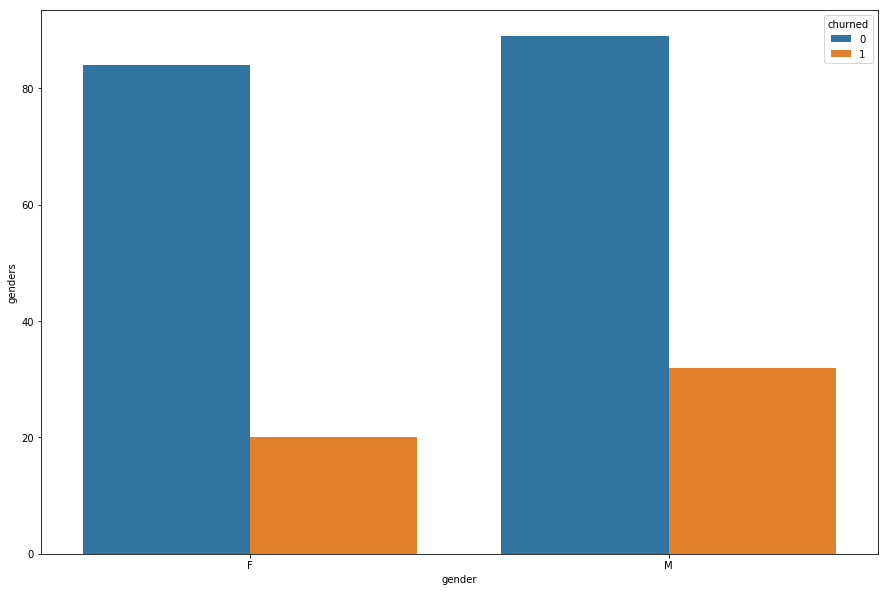

In [34]:
# creating bar plot of gender specific churned users
plt.figure(figsize=(15,10))
sns.barplot(x="gender", y="genders", hue="churned", data=gender_churn.toPandas())

In [35]:
# checking the users who downgraded their services from paid to free or churnded from the app
level_churn = spark.sql(
            '''
            SELECT 
            churned,level,COUNT(DISTINCT userId) as level_count
            FROM
            sparkify_cleaned
            GROUP BY churned, level
            ORDER BY level_count
            '''
          )
level_churn.show()

+-------+-----+-----------+
|churned|level|level_count|
+-------+-----+-----------+
|      1| paid|         36|
|      1| free|         46|
|      0| paid|        129|
|      0| free|        149|
+-------+-----+-----------+



36 users churned from the paid services while most of the users are using the free services of the platform

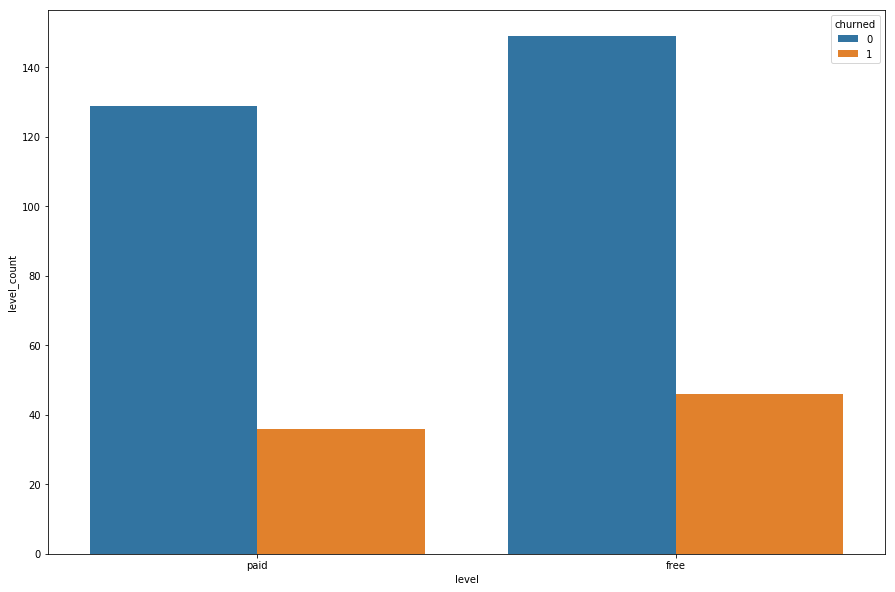

In [36]:
# creating a bar plot according to level of service churned
plt.figure(figsize=(15,10));
sns.barplot(x="level", y="level_count", hue="churned", data=level_churn.toPandas());

In [37]:
# checking the location based users who churned or not
location_churn = spark.sql(
            '''
            SELECT 
            churned,location,COUNT(DISTINCT userId) as user_count
            FROM
            sparkify_cleaned
            GROUP BY churned, location
            ORDER BY user_count DESC
            LIMIT 10 
            '''
          )
location_churn.show()

+-------+--------------------+----------+
|churned|            location|user_count|
+-------+--------------------+----------+
|      0|Los Angeles-Long ...|        13|
|      0|New York-Newark-J...|        10|
|      0|Charlotte-Concord...|         6|
|      0|Dallas-Fort Worth...|         6|
|      0|    St. Louis, MO-IL|         5|
|      0|Chicago-Napervill...|         5|
|      0|Boston-Cambridge-...|         5|
|      1|New York-Newark-J...|         5|
|      0|Phoenix-Mesa-Scot...|         5|
|      0|Atlanta-Sandy Spr...|         4|
+-------+--------------------+----------+



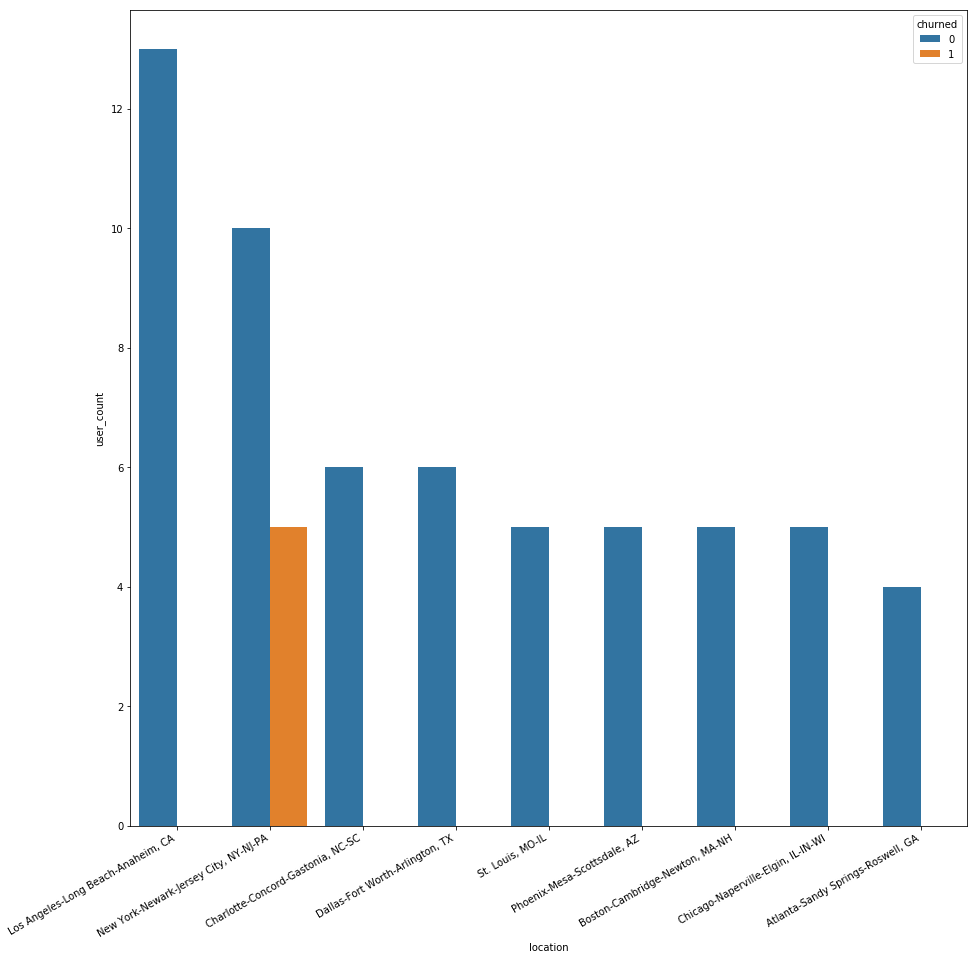

In [38]:
# bar plot for location based churned
plt.figure(figsize=(15,15));
sns.barplot(x="location", y="user_count", hue="churned", data=location_churn.toPandas());
plt.xticks(rotation=30, horizontalalignment= 'right');

In [39]:
# page level churn checking
page_churn = spark.sql(
            '''
            SELECT 
            churned,page,COUNT(DISTINCT userId) as user_count
            FROM
            sparkify_cleaned
            GROUP BY churned, page
            ORDER BY user_count DESC 
            '''
          )
page_churn.show()

+-------+--------------------+----------+
|churned|                page|user_count|
+-------+--------------------+----------+
|      0|            NextSong|       173|
|      0|                Home|       172|
|      0|           Thumbs Up|       170|
|      0|              Logout|       167|
|      0|     Add to Playlist|       165|
|      0|          Add Friend|       162|
|      0|         Roll Advert|       157|
|      0|         Thumbs Down|       155|
|      0|            Settings|       152|
|      0|                Help|       149|
|      0|             Upgrade|       131|
|      0|               About|       124|
|      0|           Downgrade|       119|
|      0|      Submit Upgrade|       102|
|      0|       Save Settings|       102|
|      0|               Error|        95|
|      1|              Cancel|        52|
|      1|            NextSong|        52|
|      1|Cancellation Conf...|        52|
|      1|                Home|        51|
+-------+--------------------+----

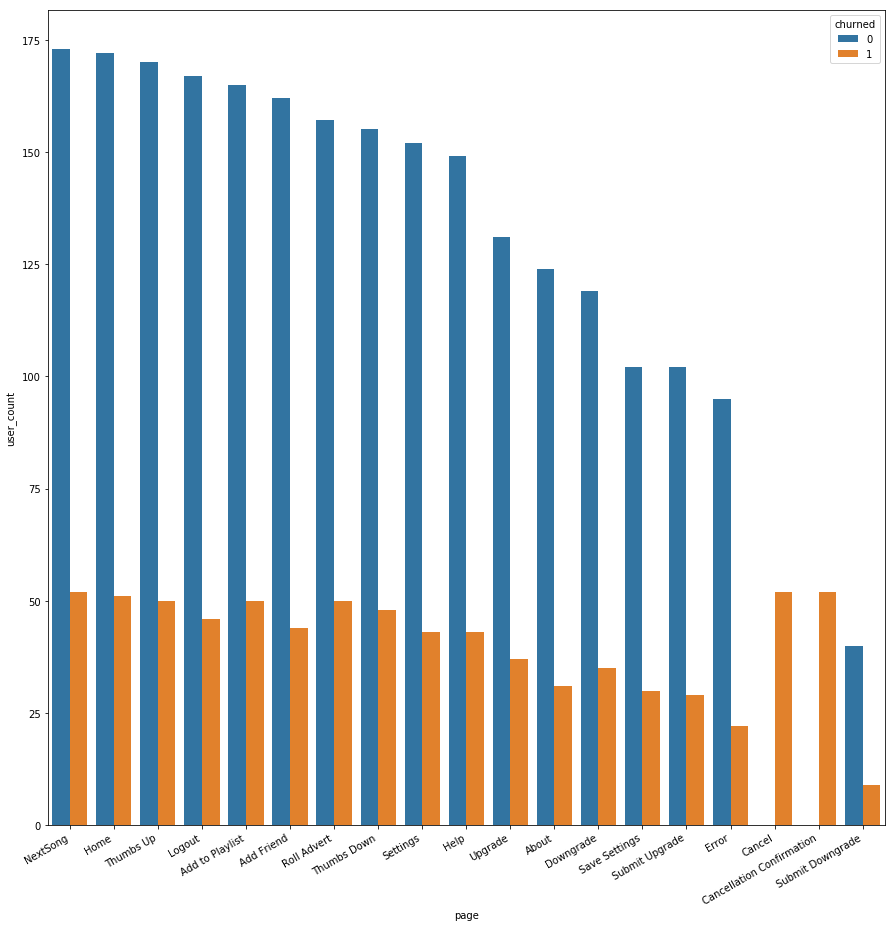

In [40]:
# plotting the page level churned users
plt.figure(figsize=(15,15));
sns.barplot(x="page", y="user_count", hue="churned", data=page_churn.toPandas());
plt.xticks(rotation=30, horizontalalignment= 'right');

52 users churned from the platform from the NextSong/Cancellation Confirmation page.

In [41]:
# checking the data schema for data types checking
sparkify_clean_churn.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- churned: long (nullable = true)



In [42]:
# selecting the common columns 
df = sparkify_clean_churn.select('userId','artist','auth','gender','length','level','location','page','song','time','churned')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [43]:
# converting dataset to pandas
df_features = df.toPandas()

In [44]:
#checking null values
df_features.isna().sum()

userId          0
artist      50046
auth            0
gender          0
length      50046
level           0
location        0
page            0
song        50046
time            0
churned         0
dtype: int64

In [45]:
# cleaning the null values 
df_clean = df.where("artist is not null and length is not null and song is not null")

In [46]:
# checking the first 20 rows
df_clean.show()

+------+--------------------+---------+------+---------+-----+--------------------+--------+--------------------+-------------------+-------+
|userId|              artist|     auth|gender|   length|level|            location|    page|                song|               time|churned|
+------+--------------------+---------+------+---------+-----+--------------------+--------+--------------------+-------------------+-------+
|100010|Sleeping With Sirens|Logged In|     F|202.97098| free|Bridgeport-Stamfo...|NextSong|Captain Tyin Knot...|2018-10-08 12:58:54|      0|
|100010|Francesca Battist...|Logged In|     F|196.54485| free|Bridgeport-Stamfo...|NextSong|Beautiful_ Beauti...|2018-10-08 13:02:16|      0|
|100010|              Brutha|Logged In|     F|263.13098| free|Bridgeport-Stamfo...|NextSong|          She's Gone|2018-10-08 13:05:32|      0|
|100010|         Josh Ritter|Logged In|     F|316.23791| free|Bridgeport-Stamfo...|NextSong|      Folk Bloodbath|2018-10-08 13:09:55|      0|
|10001

In [47]:
#checking the null values
df_clean.toPandas().isna().sum()

userId      0
artist      0
auth        0
gender      0
length      0
level       0
location    0
page        0
song        0
time        0
churned     0
dtype: int64

#### Converting some of the columns to integer type

In [48]:
#converting gender column to integer type with Maile equal to 1 and Female 0
conversion = udf(lambda x: 1 if x=="M" else 0, IntegerType())

In [49]:
#converting level column to integer type with paid equal to 1 and free 0
level_conversion = udf(lambda x: 1 if x=="Paid" else 0, IntegerType())

In [50]:
# applying the conversion udf on gender
df_clean = df_clean.withColumn('gender', conversion(df_clean.gender))

In [51]:
# applying the conversion udf on level column
df_clean = df_clean.withColumn('level', conversion(df_clean.level))

In [52]:
# creating a temp table view of the dataset
df_clean.createOrReplaceTempView("sparkify_cleaned")

#### Selecting the features to train the model

In [53]:
# selecting the features 
df_sparkify_features = spark.sql('''
          SELECT
          gender,
          level,
          SUM(case when page = 'Submit Downgrade' then 1 else 0 end) as submit_downgrade,
          SUM(case when page = 'Thumbs Down' then 1 else 0 end) as thumbs_down,
          SUM(case when page = 'Downgrade' then 1 else 0 end) as downgrade,
          SUM(case when page = 'Roll Advert' then 1 else 0 end) as roll_advert,
          SUM(case when page = 'Add to Playlist' then 1 else 0 end) as add_to_playlist,
          SUM(case when page = 'Add Friend' then 1 else 0 end) as add_friend,
          SUM(case when page = 'Thumbs Up' then 1 else 0 end) as thumbs_up,
          SUM(case when page = 'Help' then 1 else 0 end) as help,
          SUM(case when page = 'Upgrade' then 1 else 0 end) as upgrade,
          SUM(case when page = 'Error' then 1 else 0 end) as error,
          SUM(case when page = 'Submit Upgrade' then 1 else 0 end) as submit_upgrade,
          churned
          FROM sparkify_cleaned
          GROUP BY userId,churned,gender,level
          ''')


In [54]:
#checking first 20 rows of the feature
df_sparkify_features.show()

+------+-----+----------------+-----------+---------+-----------+---------------+----------+---------+----+-------+-----+--------------+-------+
|gender|level|submit_downgrade|thumbs_down|downgrade|roll_advert|add_to_playlist|add_friend|thumbs_up|help|upgrade|error|submit_upgrade|churned|
+------+-----+----------------+-----------+---------+-----------+---------------+----------+---------+----+-------+-----+--------------+-------+
|     0|    0|               0|          0|        0|          0|              0|         0|        0|   0|      0|    0|             0|      0|
|     0|    0|               0|          0|        0|          0|              0|         0|        0|   0|      0|    0|             0|      0|
|     1|    0|               0|          0|        0|          0|              0|         0|        0|   0|      0|    0|             0|      0|
|     1|    0|               0|          0|        0|          0|              0|         0|        0|   0|      0|    0|         

In [55]:
# checking schema
df_sparkify_features.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- submit_downgrade: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- downgrade: long (nullable = true)
 |-- roll_advert: long (nullable = true)
 |-- add_to_playlist: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- help: long (nullable = true)
 |-- upgrade: long (nullable = true)
 |-- error: long (nullable = true)
 |-- submit_upgrade: long (nullable = true)
 |-- churned: long (nullable = true)



#### Changing the churned column name to label to train the model

In [56]:
#changing churned column to label
df_sparkify_features = df_sparkify_features.withColumnRenamed('churned', 'label')

In [57]:
# converting label column from long to int
df_sparkify_features = df_sparkify_features.withColumn('label', col('label').cast(IntegerType()))

In [58]:
# defining input cols for vectorization and scaling
input_cols = df_sparkify_features.columns[: -1]
input_cols

['gender',
 'level',
 'submit_downgrade',
 'thumbs_down',
 'downgrade',
 'roll_advert',
 'add_to_playlist',
 'add_friend',
 'thumbs_up',
 'help',
 'upgrade',
 'error',
 'submit_upgrade']

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### Splitting the data into train and test set

In [59]:
#splitting the data into train and test
train, test = df_sparkify_features.randomSplit([0.80, 0.20], seed=42)

#### Converting the features to vectors and Standard scaler

In [60]:
# converting the features to vector assembler and Standard Scaler
assembler = VectorAssembler(inputCols=input_cols, outputCol="VectFeatures")

scaler = StandardScaler(inputCol="VectFeatures", outputCol="features")

#### Defining models for training

In [61]:
#Defining models for training
lr_model = LogisticRegression()
rf_model = RandomForestClassifier()

#### Defining Pipeline for the Classification models

In [62]:
# Models Pipeline
lr_pipeline = Pipeline(stages=[assembler, scaler, lr_model])
rf_pipeline = Pipeline(stages=[assembler, scaler, rf_model])

In [63]:
# Logistic Regression without Parameters
model = lr_pipeline.fit(train)
lr_preds = model.transform(test)
lr_evaluate = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")
f1_score_lr = lr_evaluate.evaluate(lr_preds, {lr_evaluate.metricName: "f1"})
print ('f1-Score is ', f1_score_lr)

f1-Score is  0.6553606237816765


In [64]:
# Random Forest without Parameters
model_rf = rf_pipeline.fit(train)
rf_preds = model_rf.transform(test)
rf_evaluate = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")
f1_score_rf = rf_evaluate.evaluate(rf_preds, {rf_evaluate.metricName: "f1"})
print ('f1-Score is ', f1_score_rf)

f1-Score is  0.6553606237816765


#### Defining Parameter Grids for the Classification models

In [65]:
# Models Parameters Grid for fine tuning
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr_model.maxIter, [5,10,15]) \
    .addGrid(lr_model.regParam, [0.01, 0.1]) \
    .addGrid(lr_model.elasticNetParam,[0.0, 0.8]) \
    .build()
rf_paramGrid = ParamGridBuilder()\
            .addGrid(rf_model.impurity,['entropy', 'gini']) \
            .addGrid(rf_model.maxDepth,[2, 4, 6]) \
            .build()

#### Defining the CrossValidation for the models to evaluate the model with different paramaters

In [66]:
# Cross Validation of the models
lr_crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2)
rf_crossval = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2)

### Logistic Regression

In [67]:
# fitting the train set
lr_model = lr_crossval.fit(train)
# predicting the model on test set
lr_predict = lr_model.transform(test)

In [68]:
# Evaluation of labels
lr_evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")

In [69]:
# checking f1-score of the model
lr_f1_score = lr_evaluator.evaluate(lr_predict, {lr_evaluator.metricName: "f1"})

#### Logistic Regression f1-score

In [70]:
# Printing the f1-score
print (lr_f1_score)

0.6553606237816765


### Random Forest Classification

In [71]:
# fitting and predicting the train and test set
rf_model = rf_crossval.fit(train)
rf_predict = rf_model.transform(test)

In [72]:
# Evaluating the label f1-score
rf_evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")
rf_f1_score = rf_evaluator.evaluate(rf_predict, {rf_evaluator.metricName: "f1"})

#### Random Forest Classification f1-score

In [73]:
# Printing the f1-score of Random Forest Classification
print (rf_f1_score)

0.6553606237816765


# Conclusion
According to the above f1-scores both the models Logistic Regression and Random Forest performed same in terms of precision and recall having f1-score approximately 65.5%.

As the data was messy so it took a bit of time to preprocess the data for exploration and feature engineering even after preprocessing the data during the feature engineering process some more preprocessing was required to make the dataset ready for the Apache Spark modeling purpose.

The models has been fit with and without paramter tuning but the results are somehow same while adding and tuning the parameters just increase the running time of fitting the model.

As the dataset is too small as compared to the full dataset of 12 GB so it is better to move to the Amazon EMR Cluster to perform these above steps through EDA to featuring engineering then modeling and fine tuning of the model to get even better results in terms of churn rate prediction.

### Further Improvements
1. Different models can be used to train the data other than Logistic and Random Forest to compare the f1-score of those models with the above ones.
2. More parameter grids can be used to train the model which definitely take a lot of time.
3. Large number of dataset can be used to train the models to predict the churn rate.
4. Extra features will be added to get the better results.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.